<a href="https://colab.research.google.com/github/Tim1l/currencytrading_bot_light/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_%D0%B4%D0%BB%D1%8F_%D0%B4%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC%D0%B0_ipynb%22%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Прогноз цены на золото
# Цель - предсказание следующей дневной и недельной свечи

In [ ]:
!pip install keras-tcn
!pip install keras-tcn --no-dependencies
import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras import utils #Для to_categorical
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, TimeDistributed, Bidirectional, MaxPooling1D, BatchNormalization, Flatten, Conv1D, Conv2D, RepeatVector, LSTM, GlobalMaxPooling1D, LeakyReLU, ConvLSTM2D #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов
from datetime import date 
from keras import callbacks
import math, decimal, datetime
from tensorflow.keras.utils import to_categorical
from tcn import TCN, tcn_full_summary

# Рисовать графики сразу же
%matplotlib inline

     |████████████████████████████████| 679 kB 16.0 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
newdf = pd.read_csv('/content/drive/MyDrive/Neuro/Базы/fx net/qualitydata/dataforneuronet/gold15mfull.csv', index_col='DateTime')
newdf = newdf.drop(columns=['deltapercentage', 'distance', 'delta', 'Volume', 'Обратный Volume', 'Производная от Volume', 'Вторая производная от Volume'])

In [ ]:
newdf.head()

,Open,High,Low,Close,Open-High,|Open-High|,Open*High,Open-Low,|Open-Low|,Open*Low,Open-Close,|Open-Close|,Open*Close,High-Low,|High-Low|,High*Low,High-Close,|High-Close|,High*Close,Low-Close,|Low-Close|,Low*Close,Обратный Open,Производная от Open,Вторая производная от Open,Обратный High,Производная от High,Вторая производная от High,Обратный Low,Производная от Low,Вторая производная от Low,Обратный Close,Производная от Close,Вторая производная от Close,Trend,Bullish swing,Bearish swing,Bullish pinbar,Bearish pinbar,Inside bar,Outside bar,Bullish engulfing,Bearish engulfing,WeekDay
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-04-01 18:00:00,670.4,671.6,670.1,671.6,-1.2,1.2,450240.64,0.3,0.3,449235.04,-1.2,1.2,450240.64,1.5,1.5,450039.16,0.0,0.0,451046.56,-1.5,1.5,450039.16,0.001492,-0.6,-0.4,0.001489,0.5,0.7,0.001492,-0.1,0.7,0.001489,1.3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
2007-04-01 18:15:00,671.5,671.7,671.2,671.3,-0.2,0.2,451046.55,0.3,0.3,450710.80,0.2,0.2,450777.95,0.5,0.5,450845.04,0.4,0.4,450912.21,-0.1,0.1,450576.56,0.001489,1.1,1.7,0.001489,0.1,-0.4,0.001490,1.1,1.2,0.001490,-0.3,-1.6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
2007-04-01 18:30:00,671.4,671.4,671.3,671.3,0.0,0.0,450777.96,0.1,0.1,450710.82,0.1,0.1,450710.82,0.1,0.1,450710.82,0.1,0.1,450710.82,0.0,0.0,450643.69,0.001489,-0.1,-1.2,0.001489,-0.3,-0.4,0.001490,0.1,-1.0,0.001490,0.0,0.3,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0
2007-04-01 18:45:00,671.2,671.7,671.0,671.5,-0.5,0.5,450845.04,0.2,0.2,450375.20,-0.3,0.3,450710.80,0.7,0.7,450710.70,0.2,0.2,451046.55,-0.5,0.5,450576.50,0.001490,-0.2,-0.1,0.001489,0.3,0.6,0.001490,-0.3,-0.4,0.001489,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0
2007-04-01 19:00:00,671.6,671.7,670.1,670.2,-0.1,0.1,451113.72,1.5,1.5,450039.16,1.4,1.4,450106.32,1.6,1.6,450106.17,1.5,1.5,450173.34,-0.1,0.1,449101.02,0.001489,0.4,0.6,0.001489,0.0,-0.3,0.001492,-0.9,-0.6,0.001492,-1.3,-1.5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


In [ ]:
#нормализация данных
indicator_name = 'Trend'
data_Y = newdf['Trend']

categorical_labels = to_categorical(data_Y, num_classes = 3)
print(len(categorical_labels))
print(categorical_labels[:5])

data = newdf.drop(columns=['Trend']) #удаляем их xTrain столбец с правильными ответами, т к в реальной жизни у нас не будет этого значения

data = data.values
print(data.shape, type(data))

#разделяем набор данных на обучающую, проверочную и тестовую выборки
n_train = 5000
n_val = 1000
xTrain = data[:-(n_train+n_val)]
xTest = data[-(n_train+n_val):-n_val]
xVal = data[-n_val:]
yTrain = categorical_labels[:-(n_train+n_val)]
yTest = categorical_labels[-(n_train+n_val):-n_val]
yVal = categorical_labels[-n_val:]

print('xTrain: ', xTrain.shape, '\tyTrain:', yTrain.shape,
      '\nxTest:  ', xTest.shape, '\tyTest: ', yTest.shape,
      '\nxVal:  ', xVal.shape, '\tyVal: ', yVal.shape)
xTrain.shape[0]+xTest.shape[0]+xVal.shape[0]

#проводим нормализацию
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler # проверить все
""" 
# Масштабируем только X
"""
xScaler = MinMaxScaler()  #место для экспериментов
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)
xVal = xScaler.transform(xVal)

print(xTrain.shape, xTest.shape, type(xTrain))
xTest[-1:]

334305
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]
(334305, 43) <class 'numpy.ndarray'>
xTrain:  (328305, 43) 	yTrain: (328305, 3) 
xTest:   (5000, 43) 	yTest:  (5000, 3) 
xVal:   (1000, 43) 	yVal:  (1000, 3)
(328305, 43) (5000, 43) <class 'numpy.ndarray'>


array([[0.83926465, 0.83627187, 0.83972802, 0.83899834, 0.99792531,
        0.00207469, 0.76727218, 0.01610018, 0.01610018, 0.76832353,
        0.47103275, 0.0070922 , 0.76816092, 0.01776199, 0.01776199,
        0.76781131, 0.0091954 , 0.0091954 , 0.76572242, 0.98387097,
        0.01612903, 0.7682305 , 0.05575369, 0.53846154, 0.46573982,
        0.05682408, 0.40903054, 0.57444765, 0.05549879, 0.6546091 ,
        0.40766284, 0.05585512, 0.50422195, 0.51121076, 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 1.        ]])

АРХИТЕКТУРЫ

In [ ]:
xLen = 100
xBatch = 5000

#подготовка к TCN
xTrain1 = xTrain.copy()
xTest1 = xTest.copy()
xVal1 = xVal.copy()
yTrain1 = yTrain.copy()
yTest1 = yTest.copy()
yVal1 = yVal.copy()
print(xTrain.shape)
print(yTrain.shape)

# Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain1, yTrain1, length=xLen, sampling_rate=1, stride=1, batch_size=xBatch)

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest1, yTest1, length=xLen, stride=1, batch_size=xBatch)

#Создаем генератор для теста
valDataGen = TimeseriesGenerator(xVal1, yVal1, length=xLen, stride=1, batch_size=1)

print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

print(testDataGen[0][0].shape,
      testDataGen[0][1].shape)

(328305, 43)
(328305, 3)
(5000, 100, 43) (5000, 3)
(4900, 100, 43) (4900, 3)


In [ ]:
#TCN 1 (41.57%: 2 layer - nb_filters=32)
model = Sequential()

model.add(TCN(nb_filters=64, kernel_size=3, dilations=(1,2,4,8,16,32), input_shape=(trainDataGen[0][0].shape[1], trainDataGen[0][0].shape[2]), padding='same', use_skip_connections=True, dropout_rate=0.2, return_sequences=True, activation='elu', use_batch_norm=False, use_weight_norm=True))
model.add(TCN(nb_filters=32, kernel_size=3, dilations=(1,2,4,8,16), padding='same', use_skip_connections=True, dropout_rate=0.3, return_sequences=False, activation='relu', use_batch_norm=False, use_weight_norm=True))

model.add(Dense(trainDataGen[0][1].shape[1], activation='softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 100, 64)           291980    
_________________________________________________________________
tcn_1 (TCN)                  (None, 32)                70634     
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 362,713
Trainable params: 184,387
Non-trainable params: 178,326
_________________________________________________________________


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_2 (TCN)                  (None, 100, 64)           291980    
_________________________________________________________________
tcn_3 (TCN)                  (None, 32)                70634     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 362,713
Trainable params: 184,387
Non-trainable params: 178,326
_________________________________________________________________
Epoch 1/300
66/66 [==============================] - 204s 3s/step - loss: 2.6045 - accuracy: 0.3348 - val_loss: 1.2804 - val_accuracy: 0.3314
Epoch 2/300
66/66 [==============================] - 171s 3s/step - loss: 1.6562 - accuracy: 0.3334 - val_loss: 1.3630 - val_accuracy: 0.3300
Epoch 3/300
66/66 [==============================] - 171s 3s/step - loss: 1.4943 - accur

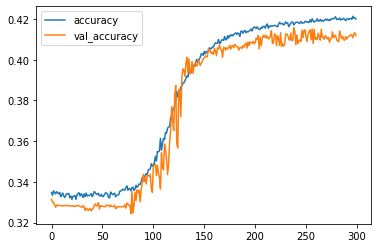

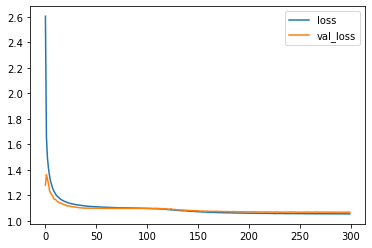

In [ ]:
model.compile(optimizer=Adam(learning_rate = 5e-05),
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

checkpoint_filepath = '/content/drive/MyDrive/Neuro/Базы/fx net/fx models/big_right_data_tcn_300ep_xBatch_5000'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# fit model
history = model.fit(trainDataGen, epochs=300, callbacks=[model_checkpoint_callback], verbose = 1,
                    validation_data=testDataGen)

print(model_checkpoint_callback.best)   #выводим лучший результат модели
model.load_weights(checkpoint_filepath) #подгружаем в модель лучшие веса

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
#дообучение модели с меньшим шагом
checkpoint_filepath = '/content/drive/MyDrive/Neuro/Базы/fx net/fx models/big_right_data_tcn_300ep_xBatch_5000'
model.load_weights(checkpoint_filepath) #подгружаем в модель лучшие веса

Epoch 1/200
66/66 [==============================] - 68s 916ms/step - loss: 1.0582 - accuracy: 0.4176 - val_loss: 1.0695 - val_accuracy: 0.4088
Epoch 2/200
66/66 [==============================] - 57s 859ms/step - loss: 1.0578 - accuracy: 0.4190 - val_loss: 1.0693 - val_accuracy: 0.4100
Epoch 3/200
66/66 [==============================] - 57s 864ms/step - loss: 1.0578 - accuracy: 0.4190 - val_loss: 1.0700 - val_accuracy: 0.4100
Epoch 4/200
66/66 [==============================] - 57s 863ms/step - loss: 1.0576 - accuracy: 0.4189 - val_loss: 1.0689 - val_accuracy: 0.4147
Epoch 5/200
66/66 [==============================] - 57s 863ms/step - loss: 1.0576 - accuracy: 0.4183 - val_loss: 1.0699 - val_accuracy: 0.4102
Epoch 6/200
66/66 [==============================] - 57s 864ms/step - loss: 1.0578 - accuracy: 0.4183 - val_loss: 1.0691 - val_accuracy: 0.4116
Epoch 7/200
66/66 [==============================] - 57s 864ms/step - loss: 1.0573 - accuracy: 0.4190 - val_loss: 1.0688 - val_accuracy:

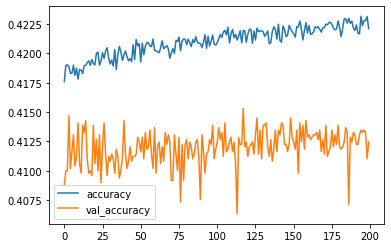

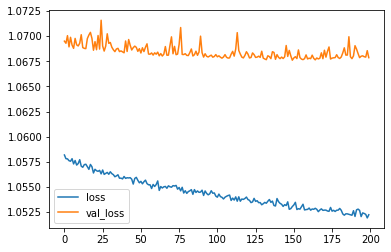

In [ ]:
model.compile(optimizer=Adam(learning_rate = 5e-05),
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

checkpoint_filepath_extralearn = '/content/drive/MyDrive/Neuro/Базы/fx net/fx models/big_right_data_tcn_300ep_xBatch_5000_extra'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_extralearn,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# fit model
history = model.fit(trainDataGen, epochs=200, callbacks=[model_checkpoint_callback], verbose = 1,
                    validation_data=testDataGen)

print(model_checkpoint_callback.best)   #выводим лучший результат модели

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
checkpoint_filepath_extralearn = '/content/drive/MyDrive/Neuro/Базы/fx net/fx models/big_right_data_tcn_300ep_xBatch_5000_extra'
model.load_weights(checkpoint_filepath_extralearn) #подгружаем в модель лучшие веса после дообучения

ПРОВЕРКА НИЖЕ!!!!!!

In [ ]:
#Проверяем на тестовой выборке

#вытаскиваем из valDataGen  x_val и y_val
x_val_list = []
y_val_list = []
for i in range(len(valDataGen)):
  x_val = valDataGen[i][0]
  y_val = valDataGen[i][1]
  x_val_list.append(x_val)
  y_val_list.append(y_val)

prediction_list = []
true_answer = 0
for i in range(len(x_val_list)):   # Выбираю пример
  x = x_val_list[i]
  #x = np.expand_dims(x, axis=0)
  prediction = model.predict(x) # Распознаём наш пример
  #print('\n',prediction)
  prediction = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)
  prediction_list.append(prediction)
  if prediction == np.argmax(y_val_list[i]):
    true_answer+=1
  
  print('Index:', i, '\tPrediction:', prediction, 'Real:', np.argmax(y_val_list[i]),
        '\t====>', y_val_list[i])

#clear_output()

print('Правильных ответов:', true_answer)
print('Ошибочных ответов:', len(x_val_list) - true_answer)
print('На тестовой выборке результат:',(true_answer/(len(x_val_list))*100),'%')

Index: 0 	Prediction: 1 Real: 0 	====> [[1. 0. 0.]]
Index: 1 	Prediction: 2 Real: 0 	====> [[1. 0. 0.]]
Index: 2 	Prediction: 2 Real: 0 	====> [[1. 0. 0.]]
Index: 3 	Prediction: 2 Real: 2 	====> [[0. 0. 1.]]
Index: 4 	Prediction: 2 Real: 0 	====> [[1. 0. 0.]]
Index: 5 	Prediction: 2 Real: 1 	====> [[0. 1. 0.]]
Index: 6 	Prediction: 2 Real: 0 	====> [[1. 0. 0.]]
Index: 7 	Prediction: 2 Real: 2 	====> [[0. 0. 1.]]
Index: 8 	Prediction: 2 Real: 0 	====> [[1. 0. 0.]]
Index: 9 	Prediction: 2 Real: 1 	====> [[0. 1. 0.]]
Index: 10 	Prediction: 1 Real: 1 	====> [[0. 1. 0.]]
Index: 11 	Prediction: 2 Real: 1 	====> [[0. 1. 0.]]
Index: 12 	Prediction: 1 Real: 1 	====> [[0. 1. 0.]]
Index: 13 	Prediction: 1 Real: 0 	====> [[1. 0. 0.]]
Index: 14 	Prediction: 1 Real: 0 	====> [[1. 0. 0.]]
Index: 15 	Prediction: 1 Real: 1 	====> [[0. 1. 0.]]
Index: 16 	Prediction: 1 Real: 1 	====> [[0. 1. 0.]]
Index: 17 	Prediction: 1 Real: 2 	====> [[0. 0. 1.]]
Index: 18 	Prediction: 1 Real: 0 	====> [[1. 0. 0.]]
Ind

In [ ]:
len(prediction_list)

900

In [ ]:
#график для проверки прогнозов
# !pip install --upgrade mplfinance
# import mplfinance as mpf
xValforcheck = newdf[-n_val:].copy()
# xValforcheck = xValforcheck.drop(columns=['Open-High', '|Open-High|', 'Open*High',
#        'Open-Low', '|Open-Low|', 'Open*Low', 'Open-Close', '|Open-Close|',
#        'Open*Close', 'High-Low', '|High-Low|', 'High*Low', 'High-Close',
#        '|High-Close|', 'High*Close', 'Low-Close', '|Low-Close|', 'Low*Close',
#        'Обратный Open', 'Производная от Open', 'Вторая производная от Open',
#        'Обратный High', 'Производная от High', 'Вторая производная от High',
#        'Обратный Low', 'Производная от Low', 'Вторая производная от Low',
#        'Обратный Close', 'Производная от Close', 'Вторая производная от Close',
#        'Trend', 'Bullish swing', 'Bearish swing', 'Bullish pinbar',
#        'Bearish pinbar', 'Inside bar', 'Outside bar', 'Bullish engulfing',
#        'Bearish engulfing', 'WeekDay'])
xValforcheck.index = pd.to_datetime(xValforcheck.index, dayfirst=True)
xValforcheck.head()

,Open,High,Low,Close,Open-High,|Open-High|,Open*High,Open-Low,|Open-Low|,Open*Low,Open-Close,|Open-Close|,Open*Close,High-Low,|High-Low|,High*Low,High-Close,|High-Close|,High*Close,Low-Close,|Low-Close|,Low*Close,Обратный Open,Производная от Open,Вторая производная от Open,Обратный High,Производная от High,Вторая производная от High,Обратный Low,Производная от Low,Вторая производная от Low,Обратный Close,Производная от Close,Вторая производная от Close,Trend,Bullish swing,Bearish swing,Bullish pinbar,Bearish pinbar,Inside bar,Outside bar,Bullish engulfing,Bearish engulfing,WeekDay
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-16 22:45:00,1852.0,1852.0,1851.1,1851.2,0.0,0.0,3429904.00,0.9,0.9,3428237.20,0.8,0.8,3428422.40,0.9,0.9,3428237.20,0.8,0.8,3428422.40,-0.1,0.1,3426756.32,0.00054,-0.3,-0.8,0.000540,-0.4,-0.1,0.00054,-0.3,-0.6,0.00054,-0.8,-0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
2021-05-16 23:00:00,1851.2,1852.3,1851.1,1851.6,-1.1,1.1,3428977.76,0.1,0.1,3426756.32,-0.4,0.4,3427681.92,1.2,1.2,3428792.53,0.7,0.7,3429718.68,-0.5,0.5,3427496.76,0.00054,-0.8,-0.5,0.000540,0.3,0.7,0.00054,0.0,0.3,0.00054,0.4,1.2,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0
2021-05-16 23:15:00,1851.5,1853.0,1851.5,1852.8,-1.5,1.5,3430829.50,0.0,0.0,3428052.25,-1.3,1.3,3430459.20,1.5,1.5,3430829.50,0.2,0.2,3433238.40,-1.3,1.3,3430459.20,0.00054,0.3,1.1,0.000540,0.7,0.4,0.00054,0.4,0.4,0.00054,1.2,0.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
2021-05-16 23:30:00,1852.9,1853.7,1852.2,1853.2,-0.8,0.8,3434720.73,0.7,0.7,3431941.38,-0.3,0.3,3433794.28,1.5,1.5,3433423.14,0.5,0.5,3435276.84,-1.0,1.0,3432497.04,0.00054,1.4,1.1,0.000539,0.7,0.0,0.00054,0.7,0.3,0.00054,0.4,-0.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
2021-05-16 23:45:00,1853.2,1853.7,1852.9,1853.0,-0.5,0.5,3435276.84,0.3,0.3,3433794.28,0.2,0.2,3433979.60,0.8,0.8,3434720.73,0.7,0.7,3434906.10,-0.1,0.1,3433423.70,0.00054,0.3,-1.1,0.000539,0.0,-0.7,0.00054,0.7,0.0,0.00054,-0.2,-0.6,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


In [ ]:
xValforcheck = xValforcheck.iloc[100:]

In [ ]:
xValforcheck

,Open,High,Low,Close,Open-High,|Open-High|,Open*High,Open-Low,|Open-Low|,Open*Low,Open-Close,|Open-Close|,Open*Close,High-Low,|High-Low|,High*Low,High-Close,|High-Close|,High*Close,Low-Close,|Low-Close|,Low*Close,Обратный Open,Производная от Open,Вторая производная от Open,Обратный High,Производная от High,Вторая производная от High,Обратный Low,Производная от Low,Вторая производная от Low,Обратный Close,Производная от Close,Вторая производная от Close,Trend,Bullish swing,Bearish swing,Bullish pinbar,Bearish pinbar,Inside bar,Outside bar,Bullish engulfing,Bearish engulfing,WeekDay,Prediction
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-18 00:45:00,1869.7,1871.7,1869.5,1871.6,-2.0,2.0,3499517.49,0.2,0.2,3495404.15,-1.9,1.9,3499330.52,2.2,2.2,3499143.15,0.1,0.1,3503073.72,-2.1,2.1,3498956.20,0.000535,-1.3,-1.8,0.000534,0.6,1.300000e+00,0.000535,0.0,0.8,0.000534,1.8,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1
2021-05-18 01:00:00,1871.6,1872.1,1870.0,1871.0,-0.5,0.5,3503822.36,1.6,1.6,3499892.00,0.6,0.6,3501763.60,2.1,2.1,3500827.00,1.1,1.1,3502699.10,-1.0,1.0,3498770.00,0.000534,1.9,3.2,0.000534,0.4,-2.000000e-01,0.000535,0.5,0.5,0.000534,-0.6,-2.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2
2021-05-18 01:15:00,1870.9,1871.4,1868.6,1870.2,-0.5,0.5,3501202.26,2.3,2.3,3495963.74,0.7,0.7,3498957.18,2.8,2.8,3496898.04,1.2,1.2,3499892.28,-1.6,1.6,3494655.72,0.000535,-0.7,-2.6,0.000534,-0.7,-1.100000e+00,0.000535,-1.4,-1.9,0.000535,-0.8,-0.2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2
2021-05-18 01:30:00,1870.3,1870.4,1868.8,1869.2,-0.1,0.1,3498209.12,1.5,1.5,3495216.64,1.1,1.1,3495964.76,1.6,1.6,3495403.52,1.2,1.2,3496151.68,-0.4,0.4,3493160.96,0.000535,-0.6,0.1,0.000535,-1.0,-3.000000e-01,0.000535,0.2,1.6,0.000535,-1.0,-0.2,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2
2021-05-18 01:45:00,1869.2,1872.0,1868.3,1871.1,-2.8,2.8,3499142.40,0.9,0.9,3492226.36,-1.9,1.9,3497460.12,3.7,3.7,3497457.60,0.9,0.9,3502699.20,-2.8,2.8,3495776.13,0.000535,-1.1,-0.5,0.000534,1.6,2.600000e+00,0.000535,-0.5,-0.7,0.000534,1.9,2.9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 22:30:00,1915.4,1915.6,1914.6,1914.6,-0.2,0.2,3669140.24,0.8,0.8,3667224.84,0.8,0.8,3667224.84,1.0,1.0,3667607.76,1.0,1.0,3667607.76,0.0,0.0,3665693.16,0.000522,0.2,-1.3,0.000522,-0.1,-6.000000e-01,0.000522,0.1,-0.8,0.000522,-0.9,-1.4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
2021-05-31 22:45:00,1914.6,1914.9,1913.8,1914.0,-0.3,0.3,3666267.54,0.8,0.8,3664161.48,0.6,0.6,3664544.40,1.1,1.1,3664735.62,0.9,0.9,3665118.60,-0.2,0.2,3663013.20,0.000522,-0.8,-1.0,0.000522,-0.7,-6.000000e-01,0.000523,-0.8,-0.9,0.000522,-0.6,0.3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2021-05-31 23:00:00,1914.0,1914.8,1913.5,1914.6,-0.8,0.8,3664927.20,0.5,0.5,3662439.00,-0.6,0.6,3664544.40,1.3,1.3,3663969.80,0.2,0.2,3666076.08,-1.1,1.1,3663587.10,0.000522,-0.6,0.2,0.000522,-0.1,6.000000e-01,0.000523,-0.3,0.5,0.000522,0.6,1.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [ ]:
xValforcheckshort = xValforcheck.drop(columns=['Open', 'High', 'Low', 'Close', 'Open-High', '|Open-High|', 'Open*High',
       'Open-Low', '|Open-Low|', 'Open*Low', 'Open-Close', '|Open-Close|',
       'Open*Close', 'High-Low', '|High-Low|', 'High*Low', 'High-Close',
       '|High-Close|', 'High*Close', 'Low-Close', '|Low-Close|', 'Low*Close',
       'Обратный Open', 'Производная от Open', 'Вторая производная от Open',
       'Обратный High', 'Производная от High', 'Вторая производная от High',
       'Обратный Low', 'Производная от Low', 'Вторая производная от Low',
       'Обратный Close', 'Производная от Close', 'Вторая производная от Close',
        'Bullish swing', 'Bearish swing', 'Bullish pinbar',
       'Bearish pinbar', 'Inside bar', 'Outside bar', 'Bullish engulfing',
       'Bearish engulfing', 'WeekDay'])

In [ ]:
count = 0
for i in range(len(xValforcheckshort)):
 if xValforcheckshort['Trend'][i] == xValforcheckshort['Prediction'][i]:
   count += 1

In [ ]:
print(count)

384


/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:45: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  category=UserWarning)


<Figure size 2600x1800 with 0 Axes>

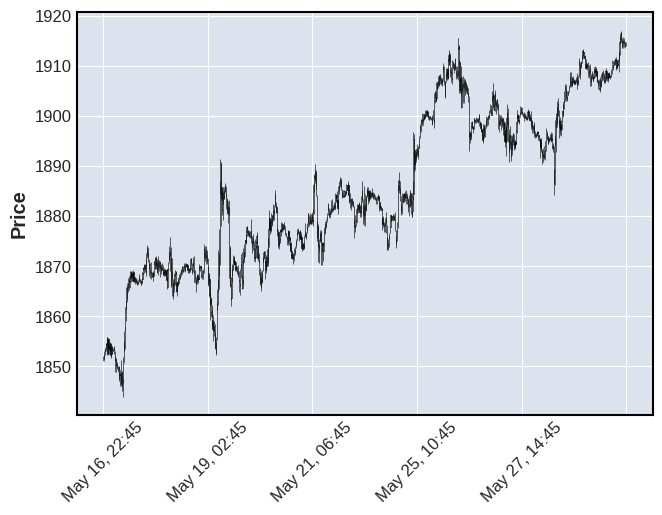

In [ ]:
plt.figure(figsize=(26,18))
mpf.plot(xValforcheck,type='candle')
plt.style.use('fivethirtyeight')   